## New page or old page?



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
not_match = df.query('(group == "treatment" & landing_page != "new_page") | (group != "treatment" & landing_page == "new_page")')
not_match.count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('(group == "treatment" & landing_page == "new_page") | (group == "control" & landing_page == "old_page")')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions below.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
duplicate_user_id = df2[df2.user_id.duplicated()]
duplicate_user_id

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(df.index[2893], inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


`4.` Use **df2** in the below cells to answer the quiz questions below.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.groupby('group').converted.mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

In [17]:
control_converted = 0.120386

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_converted = 0.118808

d. What is the probability that an individual received the new page?

In [19]:
new_page = df2.query('landing_page == "new_page"').count()
total = df2.count()
prob_new = new_page/total
prob_new.user_id

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**My answer :**

From the results of b ( control_converted = 0.120386 ) and c ( treatment_converted = 0.118808 ) , we may even consider that new treatment page actually lead less conversions than the old page. However the evidence is not sufficient:  

**The data we‘ve got is just a sample from the population, which cannot includes all the conditions. To make an inference for the whole population, we need to conduct hypothesis testing.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**My answer :**
$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$


**$p_{old}$ and $p_{new}$ are the converted rates for the old and new pages, respectivley.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [21]:
df2.converted.mean()

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
df2.converted.mean()

0.11959708724499628

c. What is $n_{new}$?

In [23]:
new_page = df2[df2.landing_page == 'new_page']
n_new = new_page.count().user_id
n_new

145310

d. What is $n_{old}$?

In [24]:
old_page = df2[df2.landing_page == 'old_page']
n_old = old_page.count().user_id
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
convert_rate_null = df2.converted.mean()

np.random.seed(1)
new_page_converted = np.random.binomial(1, convert_rate_null, n_new)
new_page_converted.mean()

0.11977152295093249

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
np.random.seed(2)
old_page_converted = np.random.binomial(1, convert_rate_null, n_old )
old_page_converted.mean()

0.11931247160538018

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

0.000459051345552311

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
p_diffs =[]
zero_one = [1, 0]
for i in range(10000):
    new_page_converted = np.random.binomial(1, convert_rate_null, n_new)
    old_page_converted = np.random.binomial(1, convert_rate_null, n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    
p_diffs = np.array(p_diffs)
p_diffs

array([ 0.00148447,  0.00145679,  0.00061735, ...,  0.00056219,
       -0.00029102,  0.00015606])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

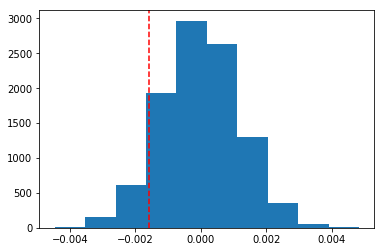

In [29]:
diff = treatment_converted - control_converted
plt.hist(p_diffs);
plt.axvline(x = diff, c = "red", linestyle='dashed');


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
p_value = (p_diffs > diff).mean()
p_value

0.9083

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**My answer :**  

The value we just computed is called P-value. **P-value is the probability of rejecting the null hypothesis ($H_0$).**  

The P-value we computed was 0.9083 which is much bigger than 5%( Type I error rate is 5%) , thus we failed to reject the **null** hypothesis.  

**In conclusion, there is no significate difference between the new and old pages, if the new page casues more money or work, we may better stay with the old version.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [32]:
df2.groupby('landing_page').converted.sum()

landing_page
new_page    17264
old_page    17489
Name: converted, dtype: int64

In [33]:
convert_old = 17489
convert_new = 17264

In [34]:
n_old = df2.query('landing_page == "old_page"').count().user_id
n_new = df2.query('landing_page == "new_page"').count().user_id

n_old, n_new

(145274, 145310)

In [35]:
import statsmodels.api as sm

data = pd.DataFrame({
    "Converted": [convert_new, convert_old],
    "Total": [n_new, n_old]
    }, index=['new', 'old'])
data 

,Converted,Total
new,17264,145310
old,17489,145274


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
zstat, P_value = sm.stats.proportions_ztest(count = data.Converted, nobs = data.Total, alternative='larger')
zstat, P_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**My answer :**  

With the z-score(Standardized Score = -1.31, which is bigger than -1.96) and p-value I've computed above, p-value ( = 0.9051,which is bigger than 0.05) is consistent with the findings in parts j ( p-value = 0.9083 ).  
[z-score and p-vaule table](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm)     

It is clear that the resulting p-value were very large compared to what we've required ( p-vaule = 0.05 ), thus failing to reject the null hypothesis.  

In conclusion, there is no significate difference between the new and old pages.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**My answer :**  

Performing Logistic Regression by encoding dummy variables.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2['intercept'] = 1
ab_page = pd.get_dummies(df2['group'])
df2['ab_page'] = ab_page['treatment']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
import statsmodels.api as sm
logit = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:09:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**My answer :**  

_What is the p-value associated with ab-page_?
* The p-value associated with **ab_page** is 0.190.  

_Why does it differ from the value you found in Part II?_
* The null and alternative hypotheses in **Part II** is a one tailed test:  $H_0: p_{new} - p_{old} \leq 0$ and $H_1: p_{new} - p_{old} > 0$ , while in **Part III** is a two tailed test:  $H_0: p_{new} - p_{old} = 0$ and $H_1: p_{new} - p_{old} \neq 0$


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**My answer :**  

_why is it a good idea to consider other factors to add into your regression model?_  

**To make the regression model and results :**

* More reliable
* More comprehensive

_Are there any disadvantages to adding additional terms into your regression model?_  

* Incomprehensible and complicated
* Multi-collinearity

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [41]:
### Create the necessary dummy variables
dummies = pd.get_dummies(df_new['country'])
df_new = df_new.join(dummies)
df_new = df_new.drop('CA', axis = 1)

In [42]:
logit = sm.Logit(df_new['converted'], df_new[['intercept','UK','US']])
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 29 May 2019   Pseudo R-squ.:               1.521e-05
Time:                        18:09:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**Based on the p-values(all bigger than 0.05), it appeared that country didn't really have an impact on conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
### Fit Your Linear Model And Obtain the Results
df_new.head()
logit = sm.Logit(df_new['converted'], df_new[['intercept','UK','US','ab_page']])
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 29 May 2019   Pseudo R-squ.:               2.323e-05
Time:                        18:09:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

**As is shown above, p-values are all bigger than 0.05, which means country and page type don't have an impact on conversion.**

In [44]:
1/np.exp(-0.0149), np.exp(0.0506), np.exp(0.0408)

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

**As is shown above, there is barely a difference between those terms and the their baseline terms.**

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [46]:
X = df_new.loc[ : , 'ab_page':'US']
y = df_new['converted']
X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.20, random_state=0)

In [47]:
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train)
preds = log_mod.predict(X_test)
confusion_matrix(y_test, preds) 



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[51094,     0],
       [ 7023,     0]])

In [48]:
'The precision score is {a} and the recall score is {b}.'.format(a=precision_score(y_test, preds),
                                                                 b=recall_score(y_test, preds))
                                                                                        

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


'The precision score is 0.0 and the recall score is 0.0.'

**As is shown above, we cannot predict whether a person will convert or not based on the "country and page type" logistic regression.**

<a id='conclusions'></a>
## Conclusions  

 

**Based on all the tests we’ve performed, it clearly showed that country and page don't have an impact on conversion.**  

**The company may better find other influencing factors that can actually have an impact on conversion.**

In [50]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0